In [1]:
import pandas as pd
import numpy as np
import textstat

In [12]:
# this only needs to be run once
%load_ext rpy2.ipython

%R library(ggplot2)
%R library(scales)
%R library(png)
%R library(grid)

array(['grid', 'png', 'scales', 'ggplot2', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U9')

### Calculate Median Reading Ease Scores

Note that the reading ease score for each pitchfork review was calculated in the `data_cleaning` notebook. The median youtube comment score is calculated in this notebook, and the other reading ease scores are from the sources provided at the end of this notebook.

**Pitchfork**

In [7]:
df_content = pd.read_csv('../data/df_content.csv')
df_content.head(2)

,reviewid,content,sentiment,reading_ease
0,22703,"“Trip-hop” eventually became a ’90s punchline,...",-0.4302,35.17
1,22721,"Eight years, five albums, and two EPs in, the ...",-0.8661,38.79


In [8]:
p4k_med_score = df_content['reading_ease'].median()
p4k_med_score

38.42

**Youtube**

In [3]:
df_yt = pd.read_csv('../data/UScomments.csv', error_bad_lines=False)
df_yt.head()

b'Skipping line 41589: expected 4 fields, saw 11\nSkipping line 51628: expected 4 fields, saw 7\nSkipping line 114465: expected 4 fields, saw 5\n'
b'Skipping line 142496: expected 4 fields, saw 8\nSkipping line 189732: expected 4 fields, saw 6\nSkipping line 245218: expected 4 fields, saw 7\n'
b'Skipping line 388430: expected 4 fields, saw 5\n'
/Users/ashjha/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,video_id,comment_text,likes,replies
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0
1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0
3,XpVt6Z1Gjjo,MY FAN . attendance,3,0
4,XpVt6Z1Gjjo,trending 😉,3,0


In [23]:
%%time
ls_med = []
for i in range(20):
    df_yt_s = df_yt.sample(10000)
    ls_med.append(df_yt_s['comment_text'].apply(lambda row: textstat.flesch_reading_ease(str(row))).median())

yt_med_score = np.mean(ls_med)
yt_med_score

CPU times: user 24.3 s, sys: 116 ms, total: 24.4 s
Wall time: 24.7 s


87.6025

In [10]:
df_r = pd.DataFrame({'source':['Reader\'s Digest', 
                                         'Time Magazine', 
                                         'Pitchfork', 
                                         'Harvard Law Review',
                                         'The Economist',
                              'Youtube comments',
                               'The New Yorker'],
                               'score':[65, 52, int(p4k_med_score), 32, 42, int(yt_med_score), 48]})
df_r.loc[df_r['source']!='Pitchfork','highlight'] = 'no'
df_r.loc[df_r['source']=='Pitchfork','highlight'] = 'p4k'
df_r.loc[df_r['source']=='Youtube comments','highlight'] = 'yt'
df_r

,source,score,highlight
0,Reader's Digest,65,no
1,Time Magazine,52,no
2,Pitchfork,38,p4k
3,Harvard Law Review,32,no
4,The Economist,42,no
5,Youtube comments,87,yt
6,The New Yorker,48,no


In [13]:
%R -i df_r

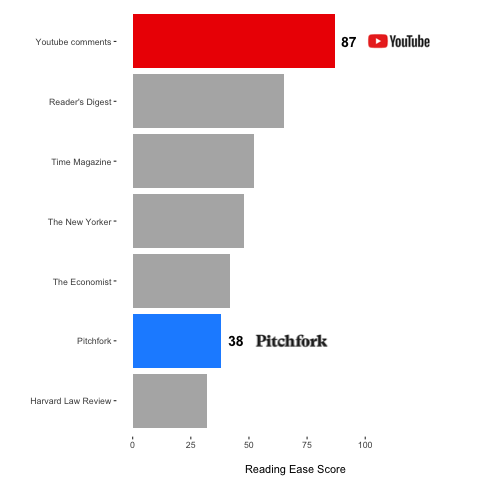

In [20]:
%%R

img_yt <- readPNG("../images/youtube.png")
img_p4k <- readPNG("../images/pitchfork.png")
g_yt <- rasterGrob(img_yt, interpolate=TRUE)
g_p4k <- rasterGrob(img_p4k, interpolate=TRUE)

bar <- (ggplot()
+ geom_bar(aes(x=reorder(source,score),y=score, fill=highlight), data=df_r, stat='identity')
+ scale_fill_manual(values = c('grey70','dodgerblue','red2'))
+ coord_flip()
+ scale_y_continuous(limits = c(0, 140), breaks = seq(0, 100, by = 25))
+ annotation_custom(g_yt, xmin=6.5, xmax=7.5, ymin=100, ymax=130)
+ annotation_custom(g_p4k, xmin=1.5, xmax=2.5, ymin=52, ymax=85)
+ annotate('text', x=7, y=93, label=df_r[df_r$source=='Youtube comments',][2], size=5, fontface='bold')
+ annotate('text', x=2, y=44.4, label=df_r[df_r$source=='Pitchfork',][2], size=5, fontface='bold')
+ labs(x='\n',
       y='\nReading Ease Score')
+ theme(panel.background=element_blank(),
        legend.position = "none"))
print(bar)

In [21]:
%R ggsave(bar,file='output_png/reading_ease.png', device=png(width=7.5, height=6.5, units="in", res=300))

R[write to console]: Saving 7.5 x 6.5 in image



References:

- https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch_reading_ease
- https://contently.com/2015/01/28/this-surprising-reading-level-analysis-will-change-the-way-you-write/